In [22]:
if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2)

# Load master dataset
ma_final <- read_csv("../../hwk2/data/output/final_ma_data.csv")

Rows: 449046 Columns: 68
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (18): contractid, state, county, org_type, plan_type, partd, snp, eghp, ...
dbl (50): source_year, planid, fips, year, n_nonmiss, avg_enrollment, n_elig...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Question 1

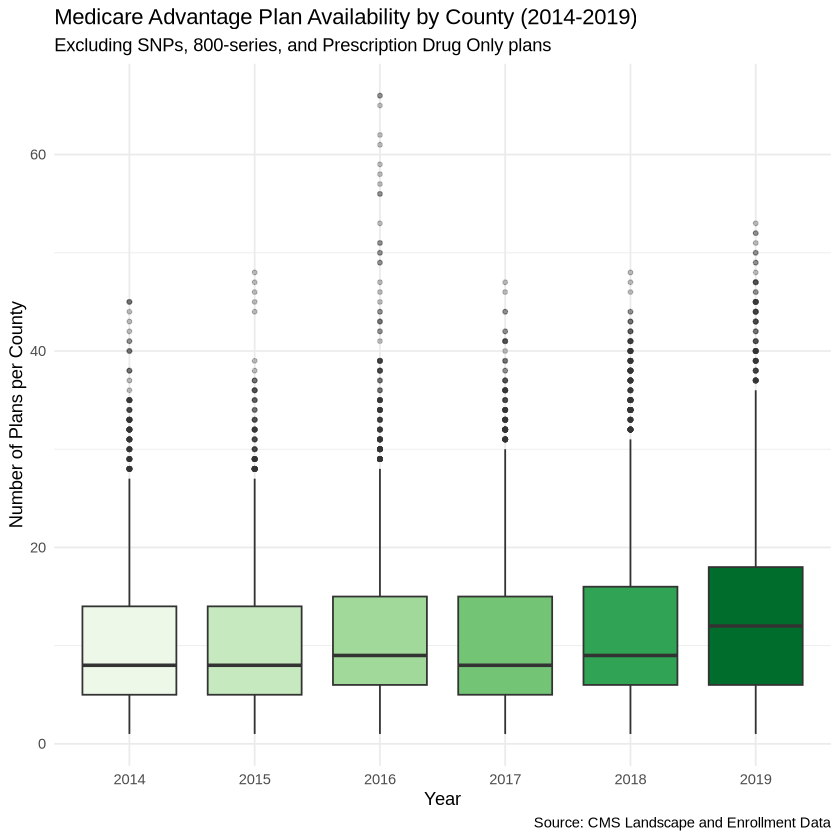

In [23]:
# Filter
ma_summary <- ma_final %>%
  filter(
    snp == "No",                                   # Remove SNPs
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900), # Remove 800-series
    !is.na(premium)                                # Part C only (removes PDPs)
  )
# Calculate counts per county/year
county_counts <- ma_summary %>%
  group_by(fips, year) %>%
  summarize(plan_count = n(), .groups = "drop")

# Make Whisker Plot
ggplot(county_counts, aes(x = as.factor(year), y = plan_count, fill = as.factor(year))) +
  geom_boxplot(outlier.size = 1, outlier.alpha = 0.3) +
  scale_fill_brewer(palette = "Greens") +
  labs(
    title = "Medicare Advantage Plan Availability by County (2014-2019)",
    subtitle = "Excluding SNPs, 800-series, and Prescription Drug Only plans",
    x = "Year",
    y = "Number of Plans per County",
    caption = "Source: CMS Landscape and Enrollment Data"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Question 2

year,Mean_Bid,Median_Bid,SD_Bid,Total_Obs
<dbl>,<dbl>,<dbl>,<dbl>,<int>
2014,879.2834,861.6301,147.1013,27574
2018,779.7197,767.1708,122.5830,31855


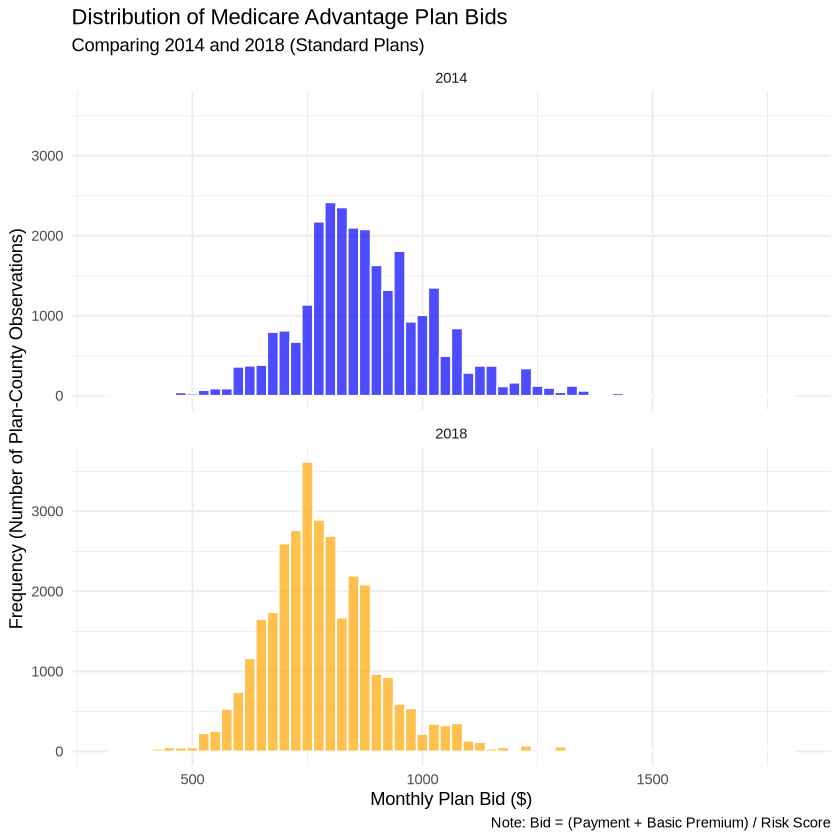

In [24]:
# Prepare data for 2014 and 2018
bid_comparison <- ma_summary %>%
  filter(
    year %in% c(2014, 2018),
    snp == "No",                                   # Standard plans only
    (as.numeric(planid) < 800 | as.numeric(planid) >= 900), # Remove 800-series
    !is.na(premium)                                # Part C benefits present
  ) %>%
  filter(!is.na(bid), bid > 0, bid < 2000) # Remove NAs and extreme outliers for clarity

# Create histograms
ggplot(bid_comparison, aes(x = bid, fill = as.factor(year))) +
  geom_histogram(binwidth = 25, alpha = 0.7, color = "white", position = "identity") +
  facet_wrap(~year, ncol = 1) +
  scale_fill_manual(values = c("2014" = "blue", "2018" = "orange")) +
  labs(
    title = "Distribution of Medicare Advantage Plan Bids",
    subtitle = "Comparing 2014 and 2018 (Standard Plans)",
    x = "Monthly Plan Bid ($)",
    y = "Frequency (Number of Plan-County Observations)",
    caption = "Note: Bid = (Payment + Basic Premium) / Risk Score"
  ) +
  theme_minimal() +
  theme(legend.position = "none")

# Calculate Summary stats
bid_comparison %>%
  group_by(year) %>%
  summarize(
    Mean_Bid = mean(bid, na.rm = TRUE),
    Median_Bid = median(bid, na.rm = TRUE),
    SD_Bid = sd(bid, na.rm = TRUE),
    Total_Obs = n()
  )

# Question 3

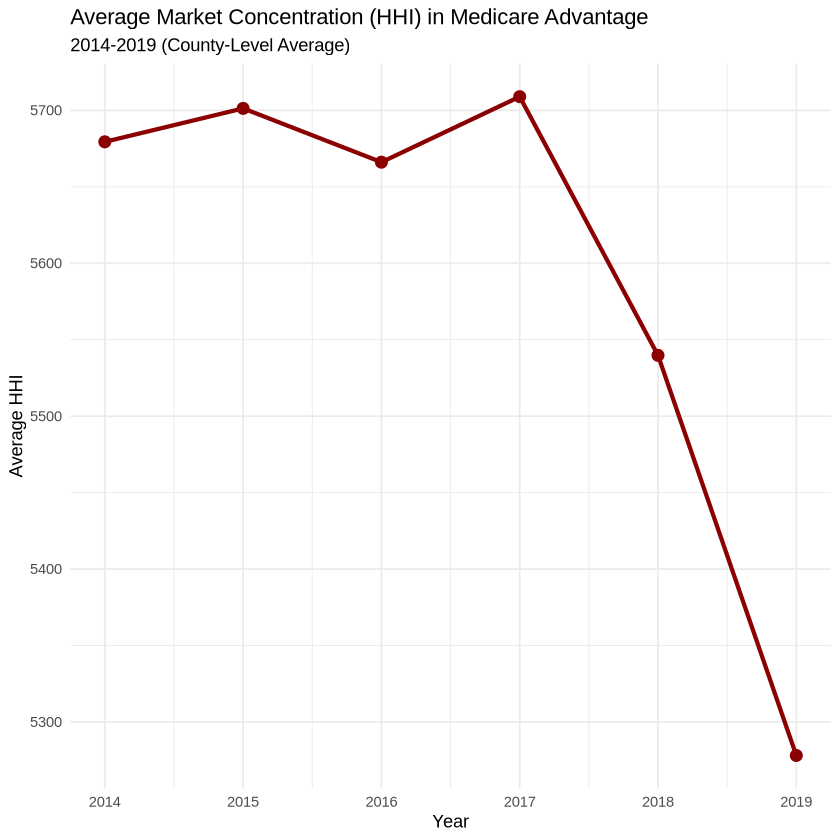

In [27]:
# Prepare Enrollment Data
# Use 'parent_org' because many contracts (contractid) belong to the same company
county_shares <- ma_summary %>% # Use filtered data
  group_by(fips, year, parent_org) %>%
  summarize(org_enrollment = sum(avg_enrollment, na.rm = TRUE), .groups = "drop_last") %>%
  mutate(
    total_county_enrollment = sum(org_enrollment, na.rm = TRUE),
    share = (org_enrollment / total_county_enrollment) * 100
  ) %>%
  filter(total_county_enrollment > 0) %>% # Avoid division by zero
  ungroup()

# Calculate HHI per County per Year
county_hhi <- county_shares %>%
  group_by(fips, year) %>%
  summarize(hhi = sum(share^2), .groups = "drop")

# Calculate National Average HHI over time
avg_hhi_trend <- county_hhi %>%
  group_by(year) %>%
  summarize(mean_hhi = mean(hhi, na.rm = TRUE))

# Plot
ggplot(avg_hhi_trend, aes(x = year, y = mean_hhi)) +
  geom_line(color = "darkred", size = 1.2) +
  geom_point(color = "darkred", size = 3) +
  scale_x_continuous(breaks = 2014:2019) +
  labs(
    title = "Average Market Concentration (HHI) in Medicare Advantage",
    subtitle = "2014-2019 (County-Level Average)",
    x = "Year",
    y = "Average HHI"
  ) +
  theme_minimal()

In [28]:
# Checking names of top companies in 2018/2019
ma_summary %>%
  filter(year %in% c(2018, 2019)) %>%
  group_by(year, parent_org) %>%
  summarize(total = sum(avg_enrollment, na.rm = TRUE), .groups = "drop") %>%
  arrange(desc(total)) %>%
  head(10)

year,parent_org,total
<dbl>,<chr>,<dbl>
2019,"UnitedHealth Group, Inc.",3291291.4
2019,Humana Inc.,3147325.5
2018,"UnitedHealth Group, Inc.",3062790.4
2018,Humana Inc.,2746107.5
2019,CVS Health Corporation,1284283.2
2018,Aetna Inc.,983421.7
2019,"Kaiser Foundation Health Plan, Inc.",923424.0
2018,"Kaiser Foundation Health Plan, Inc.",886226.3
2019,Anthem Inc.,667606.5


# Question 4

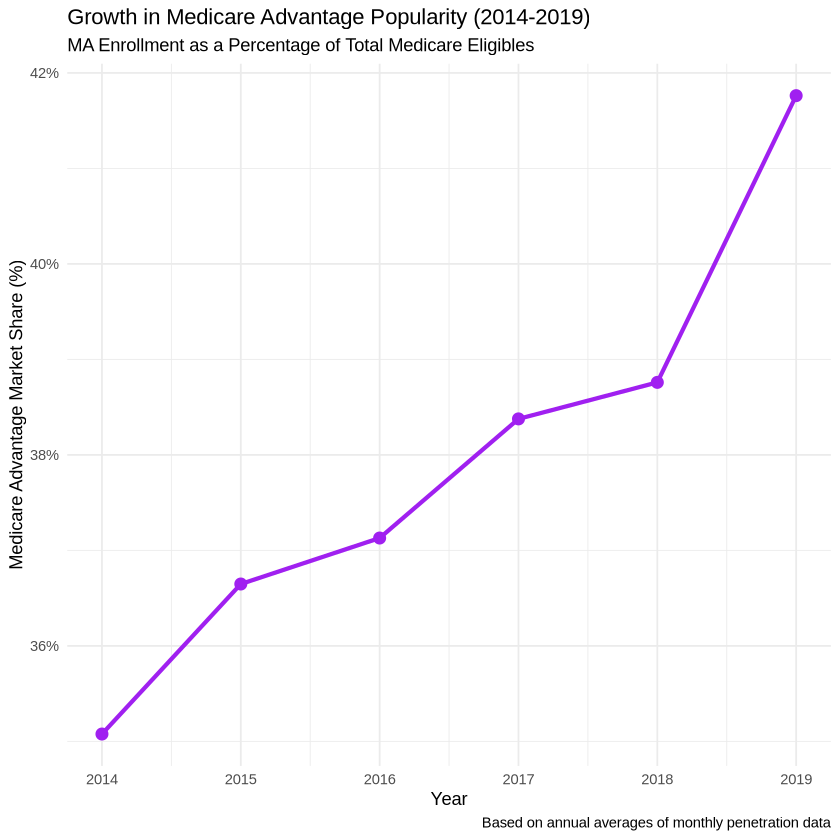

In [32]:
# Prepare  popularity data
popularity_trend <- ma_summary %>%

group_by(year) %>%
summarize(
# We sum the averages across all counties to get the national total
national_enrolled = sum(avg_enrolled, na.rm = TRUE),
national_eligible = sum(avg_eligibles, na.rm = TRUE)
) %>%
# Calculate percentage
mutate(ma_share = (national_enrolled / national_eligible) * 100)

# Plot
ggplot(popularity_trend, aes(x = year, y = ma_share)) +
  geom_line(color = "purple", linewidth = 1.2) +
  geom_point(color = "purple", size = 3) +
  scale_x_continuous(breaks = 2014:2019) +
  scale_y_continuous(labels = scales::percent_format(scale = 1)) +
  labs(
    title = "Growth in Medicare Advantage Popularity (2014-2019)",
    subtitle = "MA Enrollment as a Percentage of Total Medicare Eligibles",
    x = "Year",
    y = "Medicare Advantage Market Share (%)",
    caption = "Based on annual averages of monthly penetration data"
  ) +
  theme_minimal()